In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


In [28]:
import sys
sys.path.append(".")
import post
import importlib
importlib.reload(post)

<module 'post' from 'C:\\Users\\flash\\Project\\Yet-Another-Openpose-Implmentation\\dev\\post.py'>

In [44]:
HEIGHT=46
WIDTH=46
y_grid = tf.linspace(0.0, 1.0, HEIGHT)
x_grid = tf.linspace(0.0, 1.0, WIDTH)
yy, xx = tf.meshgrid(y_grid, x_grid, indexing='ij')  # indexing is a must, otherwise, it's just bizzare!
grid = tf.stack((yy, xx), axis=-1)


def keypoints_layer(kpts_layer,spot_size):
    """This transforms a single layer of keypoints (such as 3 keypoints of type 'right shoulder')
    the keypoint_distance creates an array of the distances from each keypoint
    and this reduces them to a single array by the  of the distances.
    :param kpts_layer must be a tf.Tensor of shape (n,3)"""
    layer_dists = tf.map_fn(keypoint_distance, kpts_layer)
    all_dists=tf.math.reduce_min(layer_dists, axis=0)
    raw = tf.exp((-(all_dists ** 2) / spot_size))
    return raw

def keypoint_distance(kpt):
    """This transforms a single keypoint into an array of the distances from the keypoint
    :param kpt must be tf.Tensor of shape (x,y,a) where a is either 0,1,2 for missing,invisible and visible"""
    if kpt[2] == tf.constant(0.0):
        return tf.ones((HEIGHT, WIDTH), dtype=tf.float32)  # maximum distance incase of empty kpt, not ideal but meh
    else:
        ortho_dist = grid - kpt[0:2]
        return tf.linalg.norm(ortho_dist, axis=-1)

def layer_PAF(joints):
    """ Makes a combined PAF for all joints of the same type
    and reduces them to a single array by averaging the vectors out
    *does not support batched input
    :param joints must be a tf.Tensor of shape (n,5)
    :return a tensor of shape (LABEL_HEIGHT, LABEL_WIDTH, 2)"""
    layer_PAFS = tf.map_fn(single_PAF, joints)
    combined = tf.math.reduce_sum(layer_PAFS, axis=0)  # averages the vectors out to combine the fields in case they intersect
    return combined

PAF_GAUSSIAN_SIGMA_SQ=0.0015
def single_PAF(joint):
    """ Makes a single vector valued PAF (part affinity field) array
    *does not support batched input
    :return a tensor of shape (LABEL_HEIGHT, LABEL_WIDTH, 2)
    """
    jpts = tf.reshape(joint[0:4], (2, 2))  # reshape to ((x1,y1),(x2,y2))
    if joint[4] == tf.constant(0.0) or tf.reduce_all(jpts[1] - jpts[0] == 0.0):
        return tf.zeros((HEIGHT, WIDTH, 2), dtype=tf.float32)  # in case of empty joint
    else:
        # this follows the OpenPose paper of generating the PAFs
        vector_full = jpts[1] - jpts[0]  # get the joint vector
        vector_length = tf.linalg.norm(vector_full)  # get joint length
        vector_hat = vector_full / vector_length  # get joint unit vector
        normal_vector = tf.stack((-vector_hat[1], vector_hat[0]))

        vectors_from_begin = grid - jpts[0]  # get grid of vectors from first joint point
        vectors_from_end = grid - jpts[1]  # get grid of vectors from second joint point

        projections = tf.tensordot(vectors_from_begin, vector_hat, 1)  # get projection on the joint unit vector
        n_projections = tf.tensordot(vectors_from_begin, normal_vector, 1)  # get projection on the joint normal unit vector

        dist_from_begin = tf.linalg.norm(vectors_from_begin, axis=-1)  # get distances from the begining, and end
        dist_from_end = tf.linalg.norm(vectors_from_end, axis=-1)

        begin_gaussian_mag = tf.exp((-(dist_from_begin ** 2) / PAF_GAUSSIAN_SIGMA_SQ))  # compute gaussian bells
        end_gaussian_mag = tf.exp((-(dist_from_end ** 2) / PAF_GAUSSIAN_SIGMA_SQ))
        normal_gaussian_mag = tf.exp((-(n_projections ** 2) / PAF_GAUSSIAN_SIGMA_SQ))

        limit = (0 <= projections) & (projections <= vector_length)  # cutoff the joint before beginning and after end
        limit = tf.cast(limit, tf.float32)
        bounded_normal_gaussian_mag = normal_gaussian_mag * limit  # bound the normal distance by the endpoints

        max_magnitude = tf.math.reduce_max((begin_gaussian_mag, end_gaussian_mag, bounded_normal_gaussian_mag), axis=0)

        vector_mag = tf.stack((max_magnitude, max_magnitude), axis=-1)

        result = vector_mag * vector_hat  # broadcast joint direction vector to magnitude field
        return result


In [4]:
kpts_many=[]
for i in range(1,10):
    for j in range(1,10):
        kpts_many.append([i/10.0,j/10.0,2])
kpts_many=np.array(kpts_many,dtype=np.float32)

In [42]:
sample_81=keypoints_layer(kpts_many,0.001)
sample_2=keypoints_layer(np.array(
        (
                [0.2,0.2,2],
                [0.8,0.8,2])
        ,dtype=np.float32),0.1)

sample=sample_81
sample=sample.numpy()
# input = sample > 0.5
# input=input.numpy()

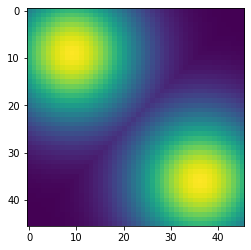

In [22]:
plt.imshow(sample)

In [7]:
##%%timeit
# islands,island_hierarchy=post.mark_islands(input)
# sorted_island_hierarchy=post.sort_island_hierarchy(island_hierarchy)
# peaks,island_max=post.islands_max(sample,islands,sorted_island_hierarchy)


In [38]:
#np.random.seed(1)
inp=np.random.random((100,100)).astype(np.float32)

In [43]:
%timeit post.find_peaks(sample,0.5)


76.8 µs ± 5.3 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
single_PAF()
